## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import re

from sqlalchemy import create_engine, text
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE

## Loading data

In [2]:
# Подключаемся к базе данных

warnings.filterwarnings("ignore")

engine = create_engine('sqlite:///data/shop_database.db')
conn = engine.connect()

In [3]:
# Загружаем таблицы 

df_pers = pd.read_sql(sql=text('SELECT * FROM personal_data'),con=conn)

In [4]:
df_pers.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [5]:
df_pers.shape

(89241, 6)

In [6]:
df_coef = pd.read_sql(sql=text('SELECT * FROM personal_data_coeffs'),con=conn)

In [7]:
df_coef.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [8]:
df_coef.shape

(104989, 5)

In [9]:
df_purch = pd.read_sql(sql=text('SELECT * FROM purchases'),con=conn)

In [10]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [11]:
df_purch.shape

(786260, 7)

In [12]:
# Загружаем утерянные данные

df_lost = pd.read_csv('data\personal_data.csv.gz', compression='gzip', header=0)

In [13]:
df_lost.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [14]:
df_lost.shape

(15748, 5)

In [15]:
# Объединяем данные о клиентах с утерянными данными

df_clients = pd.concat([df_pers, df_lost])

In [16]:
df_clients.shape

(104989, 6)

In [17]:
# Добавляем признак с коэффициентом клиента

df_clients = df_clients.merge(df_coef[['id', 'personal_coef']], on='id', how='inner')

In [18]:
df_clients.head()

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,среднее,1201,32,0.5072
1,4,0.0,35,среднее,1134,32,0.5072
2,6,1.0,52,среднее,1188,32,0.4304
3,7,0.0,37,среднее,1198,32,0.5072
4,9,0.0,48,среднее,1134,32,0.5072


## Data Preparation

### Working with personal data

In [19]:
df_clients.describe()

,id,gender,age,city,country,personal_coef
count,104989.000000,89241.000000,104989.000000,104989.000000,104989.000000,104989.000000
mean,89084.680967,0.572965,38.016707,1133.788492,31.989075,0.458363
std,51414.198487,0.494650,12.283166,179.309965,0.943848,0.062570
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.233600
25%,44532.000000,0.000000,30.000000,1134.000000,32.000000,0.430400
50%,89158.000000,1.000000,38.000000,1167.000000,32.000000,0.468800
75%,133588.000000,1.000000,46.000000,1188.000000,32.000000,0.507200
max,178004.000000,1.000000,77.000000,1213.000000,51.000000,0.558400


In [20]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         89241 non-null   float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 6.4+ MB


[Text(0.5, 0, 'Возраст'), Text(0, 0.5, 'Кол-во')]

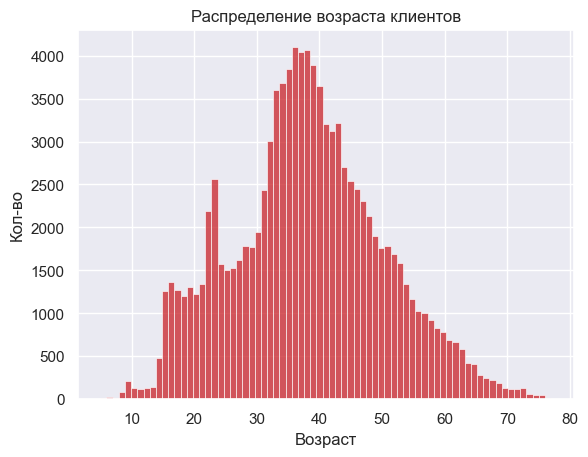

In [21]:
# Визуализируем некоторые распределения

sns.set()
fig,ax = plt.subplots()
sns.histplot(df_clients['age'], bins=73, color='#C92228')
ax.set_title('Распределение возраста клиентов')
ax.set(xlabel='Возраст', ylabel='Кол-во')

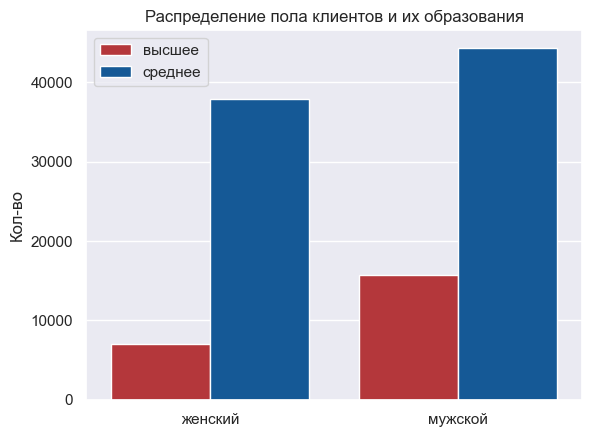

In [103]:
fig,ax = plt.subplots()
sns.countplot(x = df_clients['gender'],palette=['#C92228',"#005AAB"], hue=df_clients['education'])
ax.set_title('Распределение пола клиентов и их образования')
ax.set(xlabel=None, ylabel='Кол-во')
ax.set(xticklabels=['женский', 'мужской'])
ax.legend(title=None, loc='upper left', labels=['высшее', 'среднее'])

In [27]:
df_clients.duplicated().sum()

0

In [28]:
# Проверяем пропущенные значения

((df_clients.isna().sum() / len(df_clients)) * 100).sort_values(ascending=False)

gender           14.999667
id                0.000000
age               0.000000
education         0.000000
city              0.000000
country           0.000000
personal_coef     0.000000
dtype: float64

In [29]:
for column in df_clients.columns:
    print(column)
    print(df_clients[column].unique(), '\n')

id
[     0      4      6 ... 167019 116355  15885] 

gender
[ 0.  1. nan] 

age
[36 35 52 37 48 39 44 40 49 53 33 19 20 17 50 55 21 34 38 29 62 41 31 43
 16 32 18 30 23 25 42 24 63 45 56 58 22 47 27 51 28 26 54 57 11 46 65 13
 66 64 60 71  5 14 59 61 15 73  9  8 69 68 72 70  7 67 12 10 75  6 74 76
 77] 

education
['среднее' 'высшее'] 

city
[1201 1134 1188 1198 1190 1155  574 1178 1157 1203 1137 1204 1187 1181
 1172 1162 1185 1177 1168 1207 1166 1191 1202 1179  913 1154  338   74
 1205 1167 1159 1141 1142 1180 1150 1160 1199  609 1186 1151    3 1165
 1196 1194 1175 1161 1195 1173   33 1192 1152   48  501 1183 1156 1163
 1197 1200  218 1212    9 1176    1   73    0 1182   12 1153 1189   66
 1164   10 1170 1148 1211 1147 1158  875 1206 1171 1033 1169 1208 1174
    2   34 1133 1184   70   45  204 1135 1145 1092 1098 1093 1017  104
   62  580 1139   11  917  226 1144 1193  804  292   61   59  726   76
  307  536    7  123  515  261  588  174  269 1140  129   84  541  615
  990 1143  550  

In [30]:
# Преобразуем категориальный признак с помощью Label Encoder

le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])

In [31]:
# Разделяем выборку на обучающую и тестовую, для последущего заполнения признака о поле клиента.

df_train = df_clients[~df_clients['gender'].isna()].dropna()
print('df_train shape:',df_train.shape)

df_test = df_clients[df_clients['gender'].isna()]
print('df_test shape:',df_test.shape)

df_train shape: (89241, 7)
df_test shape: (15748, 7)


In [32]:
# В тестовой выборке признак пол не заполнен

x_train = df_train.drop(columns=['gender','id'])
y_train = df_train['gender']

x_test = df_test.drop(columns=['gender','id'])
y_test = df_test['gender']

In [33]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [31]:
# Осуществляем подбор гиперпараметров модели

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}

rs = RandomizedSearchCV(rfc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'n_estimators': 700, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_depth': 14}
Best score:  0.9999022333801678


In [32]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}

rs = RandomizedSearchCV(gbc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'subsample': 0.4, 'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 34, 'loss': 'exponential', 'learning_rate': 1, 'criterion': 'squared_error'}
Best score:  0.9999315603265982


In [34]:
# Обучаем модель с лучшей оценкой f1 и предсказываем пол клиента на тестовой выборке

model = GradientBoostingClassifier(subsample=0.4, n_estimators=300, min_samples_split=16, min_samples_leaf=2, 
                                   max_features='sqrt', max_depth=34, loss= 'exponential', learning_rate=1,
                                   criterion='squared_error').fit(x_train, y_train)
df_test['gender'] = model.predict(x_test)

In [35]:
df_test.head()

,id,gender,age,education,city,country,personal_coef
89241,101492,1.0,32,1,1188,32,0.4304
89242,42690,1.0,20,0,1134,32,0.4688
89243,113001,1.0,27,1,1187,32,0.4304
89244,163654,0.0,49,0,1160,32,0.5584
89245,69523,0.0,44,1,1137,32,0.5072


In [36]:
# Объединяем датафреймы

df_clients = pd.concat([df_train, df_test])

### Working with purchases

In [37]:
df_purch.describe()

,id,cost,product_sex,base_sale,dt
count,786260.000000,786260.000000,471548.000000,786260.000000,786260.000000
mean,89064.105357,5406.566271,0.575621,0.356883,25.129113
std,51386.509635,10394.947580,0.494249,0.479080,17.296781
min,0.000000,-30.000000,0.000000,0.000000,0.000000
25%,44435.500000,1499.000000,0.000000,0.000000,10.000000
50%,89387.500000,2999.000000,1.000000,0.000000,22.000000
75%,133427.000000,5599.000000,1.000000,1.000000,40.000000
max,178004.000000,446420.000000,1.000000,1.000000,58.000000


In [38]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [39]:
def get_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [40]:
get_outliers(df_purch['cost'])

(-4651.0, 11749.0)

[Text(0.5, 0, 'Стоимость'), Text(0, 0.5, 'Кол-во')]

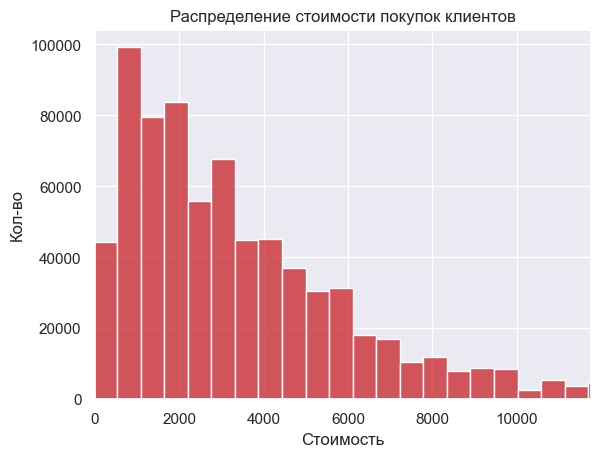

In [41]:
fig,ax = plt.subplots()
ax.set_xlim(0,11749.0)
sns.histplot(df_purch['cost'], bins=800, color='#C92228')
ax.set_title('Распределение стоимости покупок клиентов')
ax.set(xlabel='Стоимость', ylabel='Кол-во')

[[Text(0, 0, 'женcкий'), Text(1, 0, 'мужской')]]

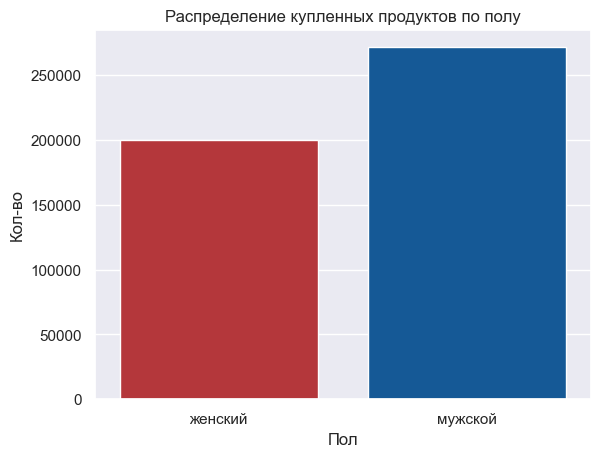

In [42]:
fig,ax = plt.subplots()
sns.countplot(x = df_purch['product_sex'],palette=['#C92228',"#005AAB"])
ax.set_title('Распределение купленных продуктов по полу')
ax.set(xlabel='Пол', ylabel='Кол-во')
ax.set(xticklabels=['женcкий', 'мужской'])

In [43]:
df_purch.duplicated().sum()

0

In [44]:
# Проверяем пропущенные значения

((df_purch.isna().sum() / len(df_purch)) * 100).sort_values(ascending=False)

product_sex    40.026454
colour         15.201587
id              0.000000
product         0.000000
cost            0.000000
base_sale       0.000000
dt              0.000000
dtype: float64

In [45]:
# Проверяем уникальные значения признаков в датафрейме

for column in df_purch.columns:
    print(column)
    print(df_purch[column].unique(), '\n')

id
[     0      3      4 ... 178001 178002 178004] 

product
['Велосипед горный женский Stern Mira 2.0 26"' 'Стол Outventure'
 'Набор Outventure: стол + 4 стула' ...
 'Клюшка детская Bauer Vapor 3X, Flex 55, P92'
 'Футболка мужская Reebok United By Fitness'
 'Бутсы мужские adidas Predator 19.3 TF'] 

colour
['белый/синий' 'зелёный' 'бежевый' ... 'бордовый/прозрачный/голубой'
 'синий/голубой/золотой/желтый' 'черный/циан'] 

cost
[ 13599   1499   4799 ...   5700  49899 174999] 

product_sex
[ 0. nan  1.] 

base_sale
[1 0] 

dt
[ 7 37 13 27 34  0  1  2 32  3  8 11 17 18 29 30  6 14 33 35 36 42 49 25
 39 55 56  4 26 28 45 51  5 15 50 52 12 16 19 21 22 23 31  9 58 41 44 57
 47 10 54 43 38 46 53 24 40 20 48] 



In [46]:
# Проверяем товары где не заполнен признак product_sex

prod = df_purch['product'][df_purch['product_sex'].isnull()].unique().tolist()
prod

['Стол Outventure',
 'Набор Outventure: стол + 4 стула',
 'Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALITY PRO',
 'Роликовые коньки детские Roces Orlando III',
 'Шлем FILA NRK FUN',
 'Роликовые коньки детские Roces Yuma TIF',
 'Набор защиты из 3-х предметов детский Reaction Rainbow',
 'Шлем для девочек Reaction Urban',
 'Роликовые коньки детские раздвижные Reaction Rainbow',
 'Куртка утепленная для девочек Outventure',
 'Кроссовки для мальчиков Geox J Sprintye Boy',
 'Бейсболка детская Nike Futura Mash Up',
 'Носки детские Demix, 2 пары',
 'Ботинки утепленные для мальчиков Reima Uskallus',
 'Кроссовки утепленные для мальчиков Skechers Razor Flex',
 'Бутсы для мальчиков PUMA ULTRA PLAY TT JR',
 'Гетры Nike Academy Over-The-Calf Football Socks',
 'Бутсы для мальчиков Nike Jr. Tiempo Legend 9 Academy TF',
 'Футболка для мальчиков Nike Dri-FIT Kylian Mbappe',
 'Бутсы для мальчиков PUMA Rapido III It Jr',
 'Лестница координационная Demix',
 'Дорожка координационная Demix',
 'Электросамокат 

In [47]:
# Заполняем признак product_sex исходя из описания товаров

df_purch['product_sex'] = df_purch['product_sex'].fillna(2)

In [48]:
# Заполняем пропущенное значение признака цвет товара значением 'другой'

df_purch['colour'] = df_purch['colour'].fillna('другой')

In [49]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,2.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27


In [50]:
# Проверяем частоту значений в признаках

for column in df_purch.columns:
    print(column)
    print(df_purch[column].value_counts(), '\n')

id
20770     569
16910     522
20570     420
35091     330
131874    326
         ... 
165413      1
12748       1
165409      1
56134       1
89967       1
Name: id, Length: 104989, dtype: int64 

product
Брюки мужские Demix                                                                                                                    4961
Шорты мужские Demix                                                                                                                    4650
Футболка мужская Demix                                                                                                                 3644
Лиф женский Joss                                                                                                                       3378
Футболка женская Demix                                                                                                                 3252
                                                                                              

In [51]:
# Объединяем дублирующиеся значения цвета

df_purch['colour'] = df_purch['colour'].replace(['чёрный'], 'черный')

In [52]:
# Обрабатываем признаки product и colour

df_purch['product'] = df_purch['product'].apply(lambda x: " ".join(re.findall('[А-Яа-я]{3,20}', x)).lower())

In [53]:
df_purch['colour'] = df_purch['colour'].apply(lambda x: x.split('/')[0].lower())

In [54]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,велосипед горный женский,белый,13599,0.0,1,7
1,0,стол,зелёный,1499,2.0,0,37
2,0,набор стол стула,бежевый,4799,2.0,0,37
3,3,бутсы мужские,белый,1599,1.0,0,13
4,3,мяч футбольный,мультицвет,7199,2.0,0,27


## A/B test evaluation

In [55]:
# Загружаем файлы которые содержат id клиентов участвовавших в A/B тесте

with open('data/ids_first_company_positive.txt') as f:
    positive = f.read()

In [56]:
elem_list = re.split(';|,| ', positive)

In [57]:
positive_id = []

for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
        

In [58]:
len(positive_id)

4964

In [59]:
with open('data/ids_first_company_negative.txt') as f:
    negative = f.read()

In [60]:
elem_list = re.split(';|,| ', negative)

In [61]:
negative_id = []

for i in elem_list:
    if i.isdigit():
        negative_id.append(int(i))

In [62]:
len(negative_id)


4961

In [63]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,велосипед горный женский,белый,13599,0.0,1,7
1,0,стол,зелёный,1499,2.0,0,37
2,0,набор стол стула,бежевый,4799,2.0,0,37
3,3,бутсы мужские,белый,1599,1.0,0,13
4,3,мяч футбольный,мультицвет,7199,2.0,0,27


In [64]:
# Выбираем покупки которые были совершены во время проведения первой рекламной компании

df_test = df_purch[(df_purch['dt'] >= 5) & (df_purch['dt'] < 17)]

In [65]:
# Группируем по id клиента, чтобы получить выручку на одного клиента

arpu_group = df_test.groupby('id', as_index=False).agg({'cost':'sum'})

In [66]:
arpu_group

,id,cost
0,0,13599
1,3,1599
2,6,17215
3,7,14497
4,9,40198
...,...,...
77141,177996,5599
77142,177997,15397
77143,177998,17794
77144,178001,35393


In [67]:
# Создаем датафрейм с клиентами которые получили скидку во время рекламной компании

positive_arpu = arpu_group.loc[arpu_group['id'].isin(positive_id), :]

In [68]:
len(positive_arpu)

4757

In [69]:
# Создаем датафрейм с клиентами которые не получили скидку

negative_arpu = arpu_group.loc[arpu_group['id'].isin(negative_id), :]

In [70]:
len(negative_arpu)

4961

**Основная гипотеза**: нет статистически значимой разницы между средней выручкой на одного пользователя в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средней выручкой на одного пользователя в тестовой и контрольной группах.

In [71]:
# Проверка нормальности распределения 

print(stats.shapiro(positive_arpu['cost']))
print(stats.shapiro(negative_arpu['cost']))

ShapiroResult(statistic=0.5344901084899902, pvalue=0.0)
ShapiroResult(statistic=0.47260046005249023, pvalue=0.0)


In [72]:
# Т.к. распределение не является нормальным, а выборки независимы, используем критерий Манна-Уитни для проверки гипотезы о среднем

mann = stats.mannwhitneyu(positive_arpu['cost'], negative_arpu['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=13632883.5, pvalue=3.977397095679975e-40)
Есть статистически значимая разница


In [73]:
print(get_outliers(positive_arpu['cost']))
print(get_outliers(negative_arpu['cost']))

(-31399.0, 70993.0)
(-24670.0, 53914.0)


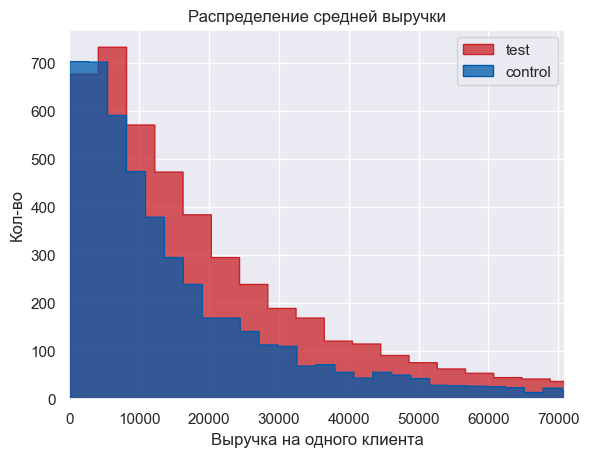

In [112]:
fig,ax = plt.subplots()
ax.set_xlim(0,70993.0)
sns.histplot(x=positive_arpu['cost'], bins=300, color='#C92228', element='step')
sns.histplot(x=negative_arpu['cost'], bins=300, color='#005AAB', element='step')
ax.set_title('Распределение средней выручки')
ax.set(xlabel='Выручка на одного клиента', ylabel='Кол-во')
ax.legend(['test','control'])

std_error_test= np.std(positive_arpu['cost']) / np.sqrt(len(positive_arpu['cost']))
std_error_control = np.std(negative_arpu['cost']) / np.sqrt(len(negative_arpu['cost']))


<ErrorbarContainer object of 3 artists>

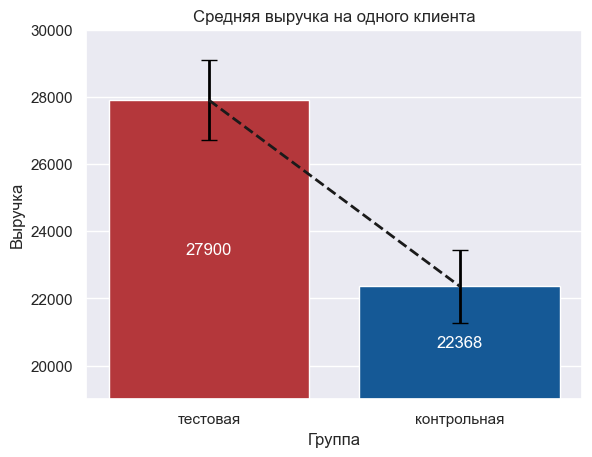

In [111]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(), 
                                                  negative_arpu['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средняя выручка на одного клиента')
ax.set(xlabel='Группа', ylabel='Выручка',  ylim=(19000, 30000))
ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(), 
                                                  negative_arpu['cost'].mean()], 
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

In [74]:
# Группируем покупки по дате и id, чтобы получить условный средний чек. 

bill_group = df_test.groupby(['dt','id'], as_index=False).agg({'cost':'sum'})

In [75]:
positive_bill = bill_group.loc[bill_group['id'].isin(positive_id), :]
len(positive_bill)

12517

In [76]:
negative_bill = bill_group.loc[bill_group['id'].isin(negative_id), :]
len(negative_bill)

11051

**Основная гипотеза**: нет статистически значимой разницы между средним чеком в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средним чеком в тестовой и контрольной группах.

In [79]:
# Проверка нормальности распределения 

print(stats.kstest(positive_bill['cost'], "norm"))
print(stats.kstest(negative_bill['cost'], "norm"))

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12, statistic_sign=-1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=39, statistic_sign=-1)


In [80]:
# В этом случае также используем критерий Манна-Уитни для проверки гипотезы о среднем чеке

mann = stats.mannwhitneyu(positive_bill['cost'], negative_bill['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=72554564.5, pvalue=7.639013623733095e-11)
Есть статистически значимая разница


In [81]:
print(get_outliers(positive_bill['cost']))
print(get_outliers(negative_bill['cost']))

(-10974.5, 26021.5)
(-10501.0, 24219.0)


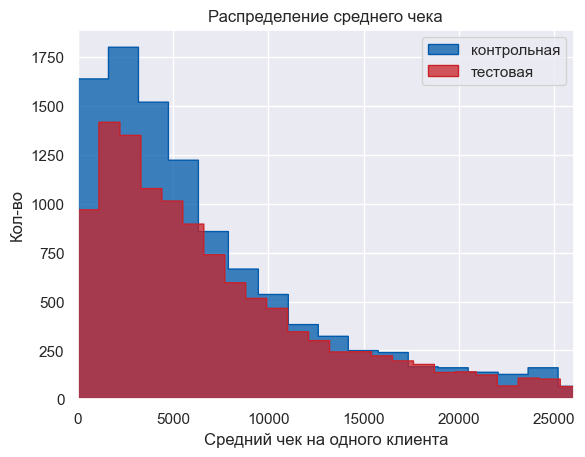

In [264]:
fig,ax = plt.subplots()
ax.set_xlim(0, 26021.5)
sns.histplot(x=negative_bill['cost'], bins=300, color='#005AAB', element='step')
sns.histplot(x=positive_bill['cost'], bins=300, color='#C92228', element='step')
ax.set_title('Распределение среднего чека')
ax.set(xlabel='Средний чек на одного клиента', ylabel='Кол-во')
ax.legend(['контрольная', 'тестовая'])

<ErrorbarContainer object of 3 artists>

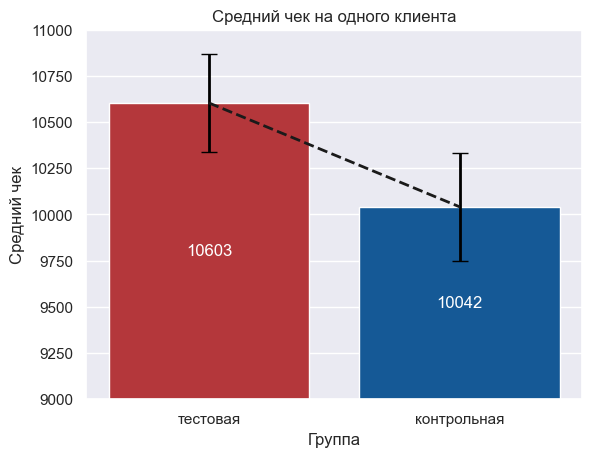

In [277]:
std_error_test= np.std(positive_bill['cost']) / np.sqrt(len(positive_bill['cost']))
std_error_control = np.std(negative_bill['cost']) / np.sqrt(len(negative_bill['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(), 
                                                  negative_bill['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средний чек на одного клиента')
ax.set(xlabel='Группа', ylabel='Средний чек', ylim=(9000, 11000))
ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(), 
                                                  negative_bill['cost'].mean()], 
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

In [84]:
# Сгруппируем данные, чтобы получить количество покупок на одного клиента за время маркетинговой компании

count_group = df_test.groupby(['id'], as_index=False).agg({'cost':'count'})

In [85]:
positive_сount = count_group.loc[count_group['id'].isin(positive_id), :]
negative_сount = count_group.loc[count_group['id'].isin(negative_id), :]

**Основная гипотеза**: нет статистически значимой разницы между средним количеством купленных товаров  в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средним количеством купленных товаров в тестовой и контрольной группах.

In [84]:
# Проверка нормальности распределения 

print(stats.kstest(positive_сount['cost'], "norm"))
print(stats.kstest(negative_сount['cost'], "norm"))

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)
KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


In [85]:
# Используем критерий Манна-Уитни

mann = stats.mannwhitneyu(positive_сount['cost'], negative_сount['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=14503562.5, pvalue=4.042645528365477e-87)
Есть статистически значимая разница


In [86]:
print(get_outliers(positive_сount['cost']))
print(get_outliers(negative_сount['cost']))

(-4.0, 12.0)
(-5.0, 11.0)


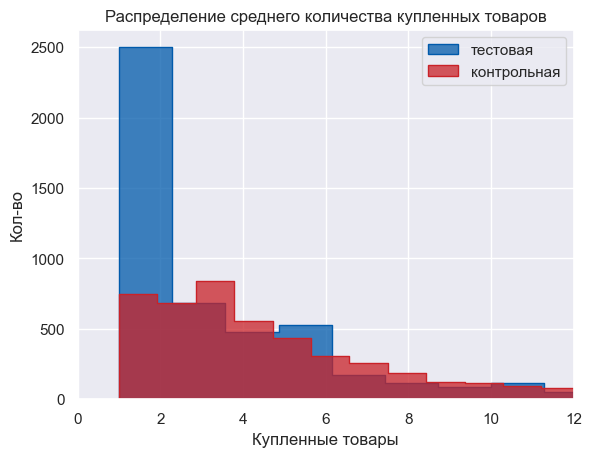

In [255]:
fig,ax = plt.subplots()
ax.set_xlim(0, 12)
sns.histplot(x=negative_сount['cost'], bins=70, color='#005AAB', element='step')
sns.histplot(x=positive_сount['cost'], bins=70, color='#C92228', element='step')
ax.set_title('Распределение среднего количества купленных товаров')
ax.set(xlabel='Купленные товары', ylabel='Кол-во')
ax.legend(['тестовая', 'контрольная'])

<ErrorbarContainer object of 3 artists>

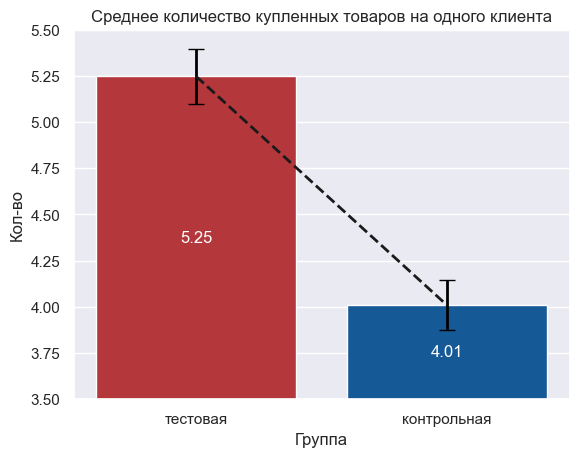

In [234]:
std_error_test= np.std(positive_сount['cost']) / np.sqrt(len(positive_сount['cost']))
std_error_control = np.std(negative_сount['cost']) / np.sqrt(len(negative_сount['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(), 
                                                  negative_сount['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.2f')
ax.set_title('Среднее количество купленных товаров на одного клиента')
ax.set(xlabel='Группа', ylabel='Кол-во', ylim=(3.5, 5.5))

ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(), 
                                                  negative_сount['cost'].mean()], 
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

**Вывод**: по итогу проведенной первой маркетинговой компании средняя выручка на одного пользователя в тестовой группе выше на 25% чем в контрольной, средний чек выше на 6% и среднее количество купленных товаров одним клиентом выше на 31%. Из этих результатов можно сделать вывод, что маркетинговая компания была эффективна. 

## Clustering

In [89]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,велосипед горный женский,белый,13599,0.0,1,7
1,0,стол,зелёный,1499,2.0,0,37
2,0,набор стол стула,бежевый,4799,2.0,0,37
3,3,бутсы мужские,белый,1599,1.0,0,13
4,3,мяч футбольный,мультицвет,7199,2.0,0,27


In [90]:
# Создаем новую таблицу с группировкой по id

df_g = df_purch.groupby('id', as_index=False).agg({'cost':'sum',
                                                   'product': pd.Series.mode,
                                                   'colour': pd.Series.mode,
                                                   'product_sex': pd.Series.mode,
                                                   'base_sale':'mean',
                                                   'dt':'max'
                                                   })

In [ ]:
# Изменяем названия признаков

dict = {'cost': 'cost_sum',
        'product': 'product_mode',
        'colour': 'color_mode',
        'product_sex': 'product_sex_mode',
        'base_sale': 'best_sale_mean',
        'dt': 'dt_max'}

df_g = df_g.rename(columns=dict)

In [ ]:
df_g

,id,cost_sum,product_mode,color_mode,product_sex_mode,best_sale_mean,dt_max
0,0,19897,"[велосипед горный женский, набор стол стула, с...","[бежевый, белый, зелёный]",2.0,0.333333,37
1,3,14596,"[бутсы мужские, кеды мужские, мяч футбольный, ...",белый,1.0,0.250000,34
2,4,31093,роликовые коньки детские,белый,2.0,0.000000,32
3,6,84085,кроссовки мужские,черный,1.0,0.400000,30
4,7,58827,бутсы для мальчиков,красный,2.0,0.384615,49
...,...,...,...,...,...,...,...
104984,177998,20732,юбка шорты женская,белый,0.0,0.750000,30
104985,177999,148289,"[велосипед городской, палатка местная]",черный,2.0,0.181818,49
104986,178001,48289,кроссовки мужские,"[другой, темно-синий]",1.0,0.090909,46
104987,178002,11397,"[бейсболка, кеды мужские, кроссовки мужские]",другой,1.0,0.000000,57


In [ ]:
# Преобразуем элементы признаков, которые состоят из списков в строку

mode_columns = ['product_mode', 'color_mode', 'product_sex_mode']

for column in mode_columns:
    df_g[column] = df_g[column].apply(lambda x: x[0] if type(x) == np.ndarray else x)

In [ ]:
# Объединяем датафрейм с данными о клиентах

df = pd.merge(left=df_clients, right=df_g, on='id', how='inner')

In [ ]:
df.head()

,id,gender,age,education,city,country,personal_coef,cost_sum,product_mode,color_mode,product_sex_mode,best_sale_mean,dt_max
0,0,0.0,36,1,1201,32,0.5072,19897,велосипед горный женский,бежевый,2.0,0.333333,37
1,4,0.0,35,1,1134,32,0.5072,31093,роликовые коньки детские,белый,2.0,0.000000,32
2,6,1.0,52,1,1188,32,0.4304,84085,кроссовки мужские,черный,1.0,0.400000,30
3,7,0.0,37,1,1198,32,0.5072,58827,бутсы для мальчиков,красный,2.0,0.384615,49
4,9,0.0,48,1,1134,32,0.5072,63290,ветровка женская,милитари,0.0,0.900000,56


In [ ]:
df = df.drop(columns=['id'])

In [ ]:
num_columns = ['age', 'personal_coef','cost_sum', 'best_sale_mean','dt_max']

In [ ]:
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

In [ ]:
# Выбираем оптимальное количество кластеров с помощью метода локтя

n_clusters = list(range(2,8))
cost = []

for n in n_clusters:
    kproto = KPrototypes(n_clusters=n, init='Cao', n_jobs=-1)
    kproto.fit_predict(df, categorical=[0,2,3,4,7,8,9])
    cost.append(kproto.cost_)

<Axes: >

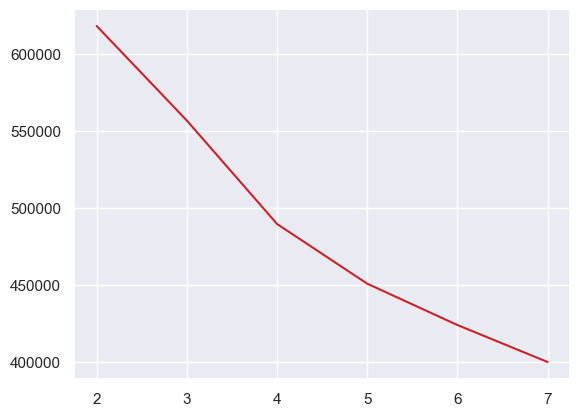

In [ ]:
sns.lineplot(x=n_clusters, y=cost, color='#C92228')

In [62]:
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df, categorical=[0,2,3,4,7,8,9])

array([1, 2, 2, ..., 1, 2, 3], dtype=uint16)

In [63]:
# Преобразуем числовые признаки датафрейма к двумерной таблице с помощью TSNE, для последующей визуализации

tsne = TSNE(n_components=2, perplexity=40)
df_emb = tsne.fit_transform(df[num_columns])
data = pd.DataFrame(df_emb)

<Axes: xlabel='0', ylabel='1'>

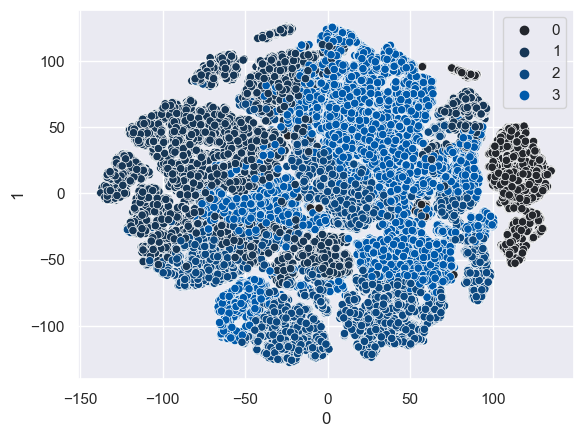

In [64]:
pallete = sns.color_palette("dark:#005AAB", as_cmap=True)
sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete)

In [65]:
# Осуществляем обратное преобразование нормализованных признаков, для того чтобы их было проще интерпритировать

df[num_columns] = scaler.inverse_transform(df[num_columns])

num_columns.extend(['education','gender'])
mode_cols = set(df.columns) - set(num_columns)

d1 = dict.fromkeys(num_columns, 'mean')
d2 = dict.fromkeys(mode_cols, pd.Series.mode)

In [66]:
d = {**d1, **d2}
df_g = df.groupby(kproto.labels_, as_index=False).agg(d)
df_g = df_g.round(2).T
df_g = df_g.rename(columns={0:'cluster 1', 1:'cluster 2', 2:'cluster 3', 3:'cluster 4'})
df_g

,cluster 1,cluster 2,cluster 3,cluster 4
age,15.83,38.93,38.24,40.87
personal_coef,0.27,0.5,0.47,0.45
cost_sum,37977.74,28459.01,26589.76,60020.9
best_sale_mean,0.33,0.61,0.16,0.21
dt_max,39.47,44.19,23.42,50.22
education,0.2,0.8,0.8,0.86
gender,0.68,0.27,0.63,0.76
product_mode,кроссовки мужские,кроссовки женские,кроссовки мужские,кроссовки мужские
product_sex_mode,1.0,0.0,2.0,1.0
city,1134,1134,1134,1134


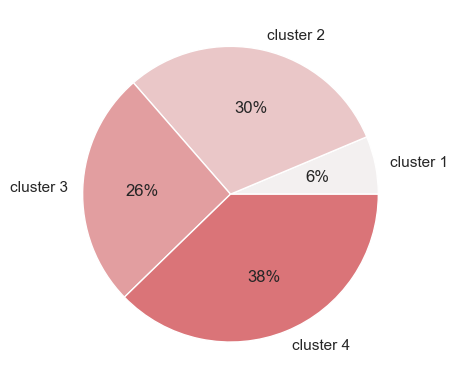

In [67]:
unique,counts = np.unique(kproto.labels_, return_counts=True)
labels = df_g.columns.tolist()
colors = sns.color_palette("light:#C92228")
plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

<p>Первый кластер (6% от общего количества) является самым молодым (средний возраст 16 лет), при этом 80% клиентов в нем имеют высшее образование. Состоит он преимущественно из клиентов мужского пола (68%) со средними расходами на одного клиента в 38 тысяч рублей и покупают они в основном товары предназначенные для мужчин. Наиболее популярным товаром в этой группе являются мужские кроссовки.</p>
<p>Второй кластер (30%) состоит преимущественно из женщин (73%) и чаще всех делает покупки при наличии скидки (61%). Самый популярный товар в этой группе женские кроссовки, а цвет - черный. Средняя сумма расходов на одного клиента 28 тысяч рублей. В основном приборетают товары для женщин.</p>
<p>Третий кластер (26%) лишь в 16% приобретает товары по скидке, средние расходы самые низкие (26 тысяч рублей) и дольше всех не делал покупок. Преимущественно приобретают универсальные товары.</p>
<p>Четвертый кластер (38%) имеет самые большие расходы в 60 тысяч рублей, самую позднюю дату покупки. На 76% состоит из мужчин с преимущественно средним образованием (86%) и возрастом в 41 год.</p>

## Сustomer purchasing model

In [52]:
with open('data/ids_first_company_positive.txt') as f:
    positive = f.read()

elem_list = re.split(';|,| ', positive)

positive_id = []

for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))

In [53]:
# Выбираем клиентов которые участвовали в первой маркетинговой компании

df_first = df_purch[(df_purch['dt'] >= 5) & (df_purch['dt'] < 17)]
product_group = df_first.groupby('id', as_index=False).agg({'product': pd.Series.mode})
first_camp = product_group.loc[product_group['id'].isin(positive_id), :]
first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
first_camp

,id,product
22,67,бутсы для мальчиков
33,92,куртка мембранная женская
42,105,электросамокат
46,122,бутылка для воды
70,192,кроссовки мужские
...,...,...
77109,177918,брюки женские
77113,177924,балетки женские
77122,177946,брюки женские
77131,177965,шорты для мальчиков


In [54]:
# Выбираем клиентов которые участвовали во второй маркетинговой компании

df_second = df_purch[(df_purch['dt'] == 15) | (df_purch['dt'] == 45)]
second_camp = df_second.groupby('id', as_index=False).agg({'product': pd.Series.mode})
second_camp['product'] = second_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
second_camp

,id,product
0,11,кроссовки женские
1,13,ворота футбольные
2,39,бомбер мужской
3,49,ветровка мужская
4,57,кеды мужские
...,...,...
19824,177966,перчатки вратарские
19825,177975,куртка утепленная мужская
19826,177979,очиститель цепи
19827,177982,бейсболка


In [55]:
# Объединяем таблицы с информацией о купленных продуктах с информацией о клиентах по id

first_df = pd.merge(left=df_clients, right = first_camp, on='id', how='inner')
first_df.shape

(4757, 8)

In [56]:
second_df = pd.merge(left=df_clients, right = second_camp, on='id', how='inner')
second_df = second_df[second_df.city == 1134]
second_df.shape

(5697, 8)

In [57]:
# Объединяем датафремы

train = first_df.append(second_df)

In [58]:
train.duplicated().sum()

161

In [59]:
train.drop_duplicates()

,id,gender,age,education,city,country,personal_coef,product
0,67,1.0,38,1,1168,32,0.4304,бутсы для мальчиков
1,92,0.0,48,1,1190,32,0.5072,куртка мембранная женская
2,105,1.0,33,1,1134,32,0.4304,электросамокат
3,122,1.0,55,1,1188,32,0.4304,бутылка для воды
4,192,1.0,45,1,1134,32,0.4304,кроссовки мужские
...,...,...,...,...,...,...,...,...
19821,130052,1.0,39,1,1134,32,0.4304,велосипедки мужские
19824,121124,0.0,38,1,1134,32,0.5072,носки пары
19825,97334,0.0,32,1,1134,32,0.5072,велосипедки женские
19826,3646,1.0,58,1,1134,32,0.4304,лента силовая


In [60]:
# Упрощаем название товаров, для сокращения кол-ва категорий

train['product'] = train['product'].apply(lambda x: x.split(' ')[0])

In [61]:
train['product'].nunique()

428

In [95]:
train['product'].value_counts()

кроссовки      1892
брюки          1119
кеды            764
полуботинки     382
велосипед       368
               ... 
дартс             1
гидролиния        1
пикниковый        1
эспадрильи        1
сидушка           1
Name: product, Length: 428, dtype: int64

In [62]:
# Создаем тестовый датафрейм на котором необходимо применить модель

test = df_clients[(df_clients.city == 1188) & (df_clients.country == 32)]
test.shape

(12438, 7)

In [80]:
x_train = train.drop(columns=['id', 'product'])
y_train = train['product']

x_test = test.drop(columns=['id'])

In [64]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

In [73]:
# Подбираем гиперпараметры модели

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          'class_weight': ('balanced', None)}

rs = RandomizedSearchCV(rfc, params, cv=kf, scoring='f1_micro', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_depth': 50, 'class_weight': None}
Best score:  0.1740006237436589


In [74]:
# Обучаем модель с лучшими гиперпараметрами

model = RandomForestClassifier(n_estimators=300, min_samples_split=12, min_samples_leaf=8, max_depth=50, class_weight=None)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=8, min_samples_split=12,
                       n_estimators=300)

In [89]:
model_pred = model.predict(x_test)

In [91]:
x_test['product'] = model_pred

In [92]:
x_test.head()

,gender,age,education,city,country,personal_coef,product
2,1.0,52,1,1188,32,0.4304,кроссовки
9,1.0,53,1,1188,32,0.4304,кроссовки
20,1.0,21,0,1188,32,0.4688,кроссовки
21,1.0,35,0,1188,32,0.4688,кроссовки
44,0.0,37,1,1188,32,0.5072,брюки


In [94]:
x_test['product'].value_counts()

кроссовки    9865
брюки        2472
ветровка      101
Name: product, dtype: int64